In [1]:
import sys
sys.path.append("..")

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
from reco_systems.filter import filter_df
from reco_systems.user_game_matrix import *

from surprise import NMF
from surprise import Dataset
from surprise.reader import Reader
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE

from scipy.spatial.distance import cdist
sns.set_theme()

# Data filtering by reviews

In [2]:
folder = "../database_cleaned"
avis_clean  = pd.read_csv(f"{folder}/avis_clean.csv", index_col=0)
jeux_clean  = pd.read_csv(f"{folder}/jeux_clean.csv", index_col=0)
users       = pd.read_csv(f"{folder}/users.csv", index_col=0)

min_reviews = 10 # change to set one
# filter data with the minimum reviews
rev_filter = filter_df(avis_clean, min_reviews)

11201 10549
2252 2676
1957 2618
1947 2616
1946 2615
1945 2614


# NNMF

In [3]:
model = NMF(n_factors=20, random_state=42, biased=False, reg_pu= 0.1, reg_qi= 0.1)
data = Dataset.load_from_df(rev_filter[["User id", "Game id", "Rating"]], reader=Reader(rating_scale=(0, 10)))
trainset = data.build_full_trainset()
nmf = model.fit(trainset)

# Extract matrices
U = nmf.pu  # User-feature matrix (W)
G = nmf.qi  # Item-feature matrix (H)

games_ids = np.array([trainset.to_raw_iid(i) for i in range(len(G))])
users_ids = np.array([trainset.to_raw_uid(u) for u in range(len(U))])
G = G[np.argsort(games_ids), :]
G

array([[0.14382481, 0.74444682, 0.54067499, ..., 0.10409893, 0.01784198,
        0.01026847],
       [1.15853361, 0.66935085, 0.70442709, ..., 0.38688394, 0.35072878,
        0.48537336],
       [0.55548329, 0.50590919, 0.54736474, ..., 0.41276769, 0.74742814,
        0.7906489 ],
       ...,
       [1.15378271, 0.75840296, 1.086939  , ..., 1.07757492, 0.46011419,
        0.59921417],
       [0.54360927, 0.94284411, 0.27739629, ..., 0.49414539, 0.32245009,
        0.58386953],
       [0.24266537, 0.68619341, 0.14901347, ..., 0.23433089, 0.74378474,
        0.94266405]])

## User-tag one hot encoding matrix

In [4]:
# create user-game matrix
user_game_ratings, mask_ratings, users_table_assoc, games_table_assoc = get_matrix_user_game(rev_filter)
filter_games_index = pd.merge(rev_filter["Game id"].drop_duplicates(), games_table_assoc.reset_index(), on="Game id")
filter_users_index = pd.merge(rev_filter["User id"].drop_duplicates(), users_table_assoc.reset_index(), on="User id")

filter_games_index.columns = ["Game id", "Game index"]
filter_users_index.columns = ["User id", "User index"]

In [5]:
users_tags = filter_users_index.merge(avis_clean, on="User id").merge(jeux_clean, on="Game id")[["User id", "Type"]]
users_tags["Type"] = users_tags["Type"].str.split("|")
users_tags = users_tags.explode("Type")
users_tags["Type"] = users_tags["Type"].str.strip().str.lower()
users_tags = users_tags.drop_duplicates()

users_tags = users_tags.pivot_table(index="User id", columns="Type", aggfunc="size", fill_value = 0, dropna=False)
users_tags

Type,abstrait,affrontement,afrique,alignement,amateur,ambiance,animaux,antiquité,archive,art,...,tv & cinéma,vampire,vikings,ville,volcan,vote,zombies,équilibre,équipe,NaN
User id,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,0,1,1,1,0,0,...,0,0,0,1,0,0,1,0,0,1
1,1,1,1,1,1,1,1,1,1,1,...,1,0,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,0,1,...,1,0,0,1,1,0,0,1,1,1
3,1,1,0,1,1,1,1,1,0,1,...,1,0,0,1,1,0,1,0,1,1
4,0,1,0,0,0,1,1,0,0,0,...,1,1,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9509,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9583,0,1,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
9596,0,1,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,1


## Game-tag one hot encoding matrix

In [6]:
games_filter = pd.merge(jeux_clean, filter_games_index, on="Game id")
games_exploded = games_filter.copy()
games_exploded["Type"] = games_filter[["Game id", "Type"]]["Type"].str.split('|')

games_exploded = games_exploded.explode("Type")
games_exploded["Type"] = games_exploded["Type"].str.strip().str.lower()
games_exploded = games_exploded.drop_duplicates()

games_tags = games_exploded.pivot_table(index="Game id", columns="Type", aggfunc='size', fill_value=0, dropna=False)
games_tags

Type,abstrait,affrontement,afrique,alignement,amateur,ambiance,animaux,antiquité,archive,art,...,tv & cinéma,vampire,vikings,ville,volcan,vote,zombies,équilibre,équipe,NaN
Game id,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10508,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Delete rare tags

In [7]:
tags_freq = pd.DataFrame(index=games_tags.columns)
tags_freq["Sum"] = games_tags.apply(sum, axis=0)
tags_freq = tags_freq.reset_index().sort_values(by="Sum", ascending=False)

print(tags_freq[tags_freq["Sum"] < 20])
# Delete unpopular tags
tags_filter = tags_freq[tags_freq["Sum"] >= 20]
tags_filter = tags_filter.dropna()
games_tags = games_tags.loc[:, tags_filter["Type"].values]
users_tags = users_tags.loc[:, tags_filter["Type"].values]
games_tags.shape, tags_filter.shape, users_tags.shape
games_tags

                   Type  Sum
89           immobilier   19
99       jeux de guerre   19
75             far-west   19
139       préhistorique   18
68               enigme   18
..                  ...  ...
165             vampire    1
166             vikings    1
65   enchères anglaises    1
168              volcan    1
53            duplicate    1

[88 rows x 2 columns]


Type,jeux de plateau,jeux de cartes,"hasard (dé, cartes, ...)",placement,affrontement,combinaison,gestion,déplacement,médiéval-fantastique,majorité,...,draft,pirate,historique,jeu de logique,jeux de dés,pari,créativité,transport de marchandise,lettres / mots,zombies
Game id,,,,,,,,,,,,,,,,,,,,,
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
25,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10507,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10508,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10514,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# #sns.set_theme(rc={'figure.figsize':(6,4)})
# sns.histplot(tags_freq["Sum"], ax=ax1)

# tags_limit = tags_freq[tags_freq["Sum"] < 200]
# sns.histplot(tags_limit["Sum"], ax=ax2)

# plt.suptitle("Tags apperance distribution")
# ax1.set_xlabel("Number of tags")
# ax2.set_xlabel("Number of tags")

# ax1.set_ylabel("Number of games")
# ax2.set_ylabel("Number of games")

In [9]:
# plt.imshow(G[:100, :], aspect="auto")
# plt.grid(False)

## Games clustering (NNMF profiles based)

In [8]:
sns.set_theme(rc={"figure.figsize":(6, 4)})
mean_inertia = []
inter_centers_dist, separability = [], []
nb_clusters = np.arange(5, 60, 5)
for n in nb_clusters:
    kmeans = KMeans(n_clusters=n, random_state=42) 
    kmeans.fit(G) 

    #distances = cdist(G, kmeans.cluster_centers_, metric="sqeuclidean")
    
    #distances = pd.DataFrame({"Distance_centroid": np.take_along_axis(distances, kmeans.labels_[..., None], axis=1).flatten(),
    #                          "Cluster": kmeans.labels_})
    mean_inertia.append(kmeans.inertia_ / n)
    
    centroids_dist = cdist(kmeans.cluster_centers_, kmeans.cluster_centers_, metric="euclidean")
   
    mean = np.sum(centroids_dist) / (centroids_dist.size - centroids_dist.shape[0])
    inter_centers_dist.append(mean)
    separability.append(np.min(centroids_dist[centroids_dist > 0]))
    #scores.append(kmeans.inertia_)

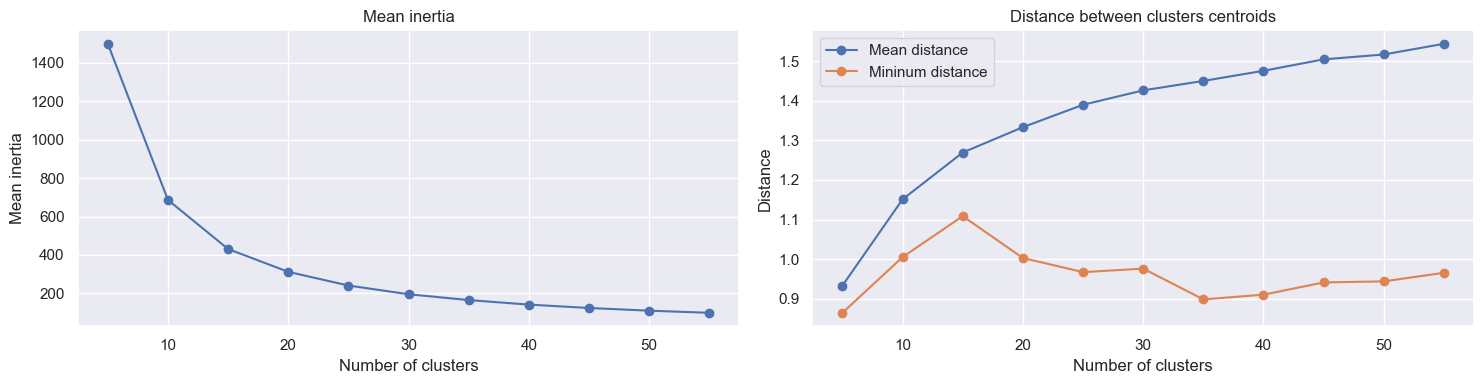

In [53]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

ax1.plot(nb_clusters[:20], mean_inertia[:20], marker='o')
ax1.set_title("Mean inertia")
ax1.set_xlabel("Number of clusters")
ax1.set_ylabel("Mean inertia")

ax2.plot(nb_clusters[:20], inter_centers_dist[:20], marker='o', label="Mean distance")
ax2.plot(nb_clusters[:20], separability[:20], marker='o', label="Mininum distance")

ax2.set_title("Distance between clusters centroids")
ax2.set_xlabel("Number of clusters")
ax2.set_ylabel("Distance")

plt.legend()
plt.tight_layout()
fig.savefig("../images/nnmf_kmeans_metrics.svg", format="svg", bbox_inches="tight")

### KMeans clustering + stats

In [8]:
#sns.set_theme(rc={"figure.figsize":(7, )})
NB_CLUSTERS = 30
kmeans = KMeans(n_clusters=NB_CLUSTERS, random_state=42) 
distances = kmeans.fit_transform(G) 
game_labels = kmeans.labels_ 
print(distances.shape)
# # Distances from centroids (calc to all centroids, then select only necessary)
#distances = np.power(cdist(G, kmeans.cluster_centers_, metric="euclidean"), 2)

games_clusters_dist = pd.DataFrame({"Game id":games_tags.index,
                        "Distance_centroid": np.take_along_axis(distances, kmeans.labels_[..., None], axis=1).flatten(),
                         "Cluster": kmeans.labels_})

# Intra-cluster distance
cluster_mean_dist = games_clusters_dist.groupby("Cluster")["Distance_centroid"].mean().reset_index()

# Ratings per cluster
games_means = rev_filter[["Game id", "Rating"]].groupby("Game id").mean().reset_index()
clusters_ratings = games_clusters_dist.merge(games_means[["Game id", "Rating"]], on="Game id")
means = clusters_ratings[["Cluster", "Rating"]].groupby(by="Cluster").agg(["mean", "std"])
means.columns = means.columns.to_flat_index()
means = means.reset_index()

(2614, 30)


In [9]:
std = games_clusters_dist.groupby("Cluster")["Distance_centroid"].std().reset_index().rename(columns={"Distance_centroid":"Std"})
clusters_dist_info = cluster_mean_dist.rename(columns={"Distance_centroid":"Mean"}).merge(std, on="Cluster")

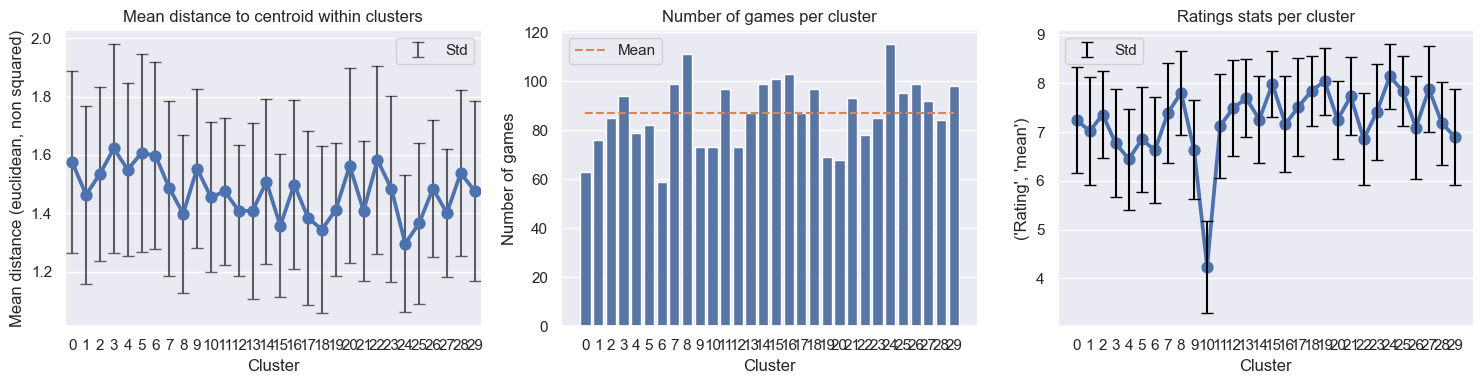

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Distance intra-cluster
ax1.errorbar(clusters_dist_info["Cluster"], clusters_dist_info["Mean"], yerr=clusters_dist_info["Std"], color="black", fmt='none', capsize=4, label="Std", alpha=0.6)
sns.pointplot(data=clusters_dist_info, x="Cluster", y="Mean", ax=ax1)
#ax1.hlines(clusters_dist_info["Mean"].mean(), 0, 29, colors=sns.color_palette("deep")[1], linestyles="dashed", label="Mean")

ax1.set_ylabel("Mean distance (euclidean, non squared)")
ax1.set_title("Mean distance to centroid within clusters")

# Games per cluster
sns.barplot(data=games_clusters_dist["Cluster"].value_counts(), ax=ax2)
ax2.hlines(games_clusters_dist["Cluster"].value_counts().mean(), 0, 29, colors=sns.color_palette("deep")[1], linestyles="dashed", label="Mean")
ax2.set_title("Number of games per cluster")
ax2.set_ylabel("Number of games")
# Ratings per cluster
sns.pointplot(data=means, x="Cluster", y=('Rating', 'mean'), ax=ax3)
plt.errorbar(means["Cluster"], means[('Rating', 'mean')], yerr=means[('Rating', 'std')], color="black", fmt='none', capsize=4, label="Std")
ax3.legend()
ax3.set_title("Ratings stats per cluster")

ax1.legend()
ax2.legend()

plt.tight_layout()
fig.savefig("../images/clusters_info1.svg", format="svg", bbox_inches="tight")


### Tags frequency per cluster

In [14]:
clusters_tags = games_clusters_dist.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T @ games_tags
clusters_tags_normal = clusters_tags / clusters_tags.sum(axis=0) # normalize

	
clusters_tags_df = clusters_tags_normal.stack().to_frame().reset_index()
clusters_tags_df.columns = ["Cluster", "Type", "Frequency"]
probas_cluster = clusters_tags_df.pivot_table(index="Type", columns="Cluster", values="Frequency")

Text(154.75, 0.5, 'Categories')

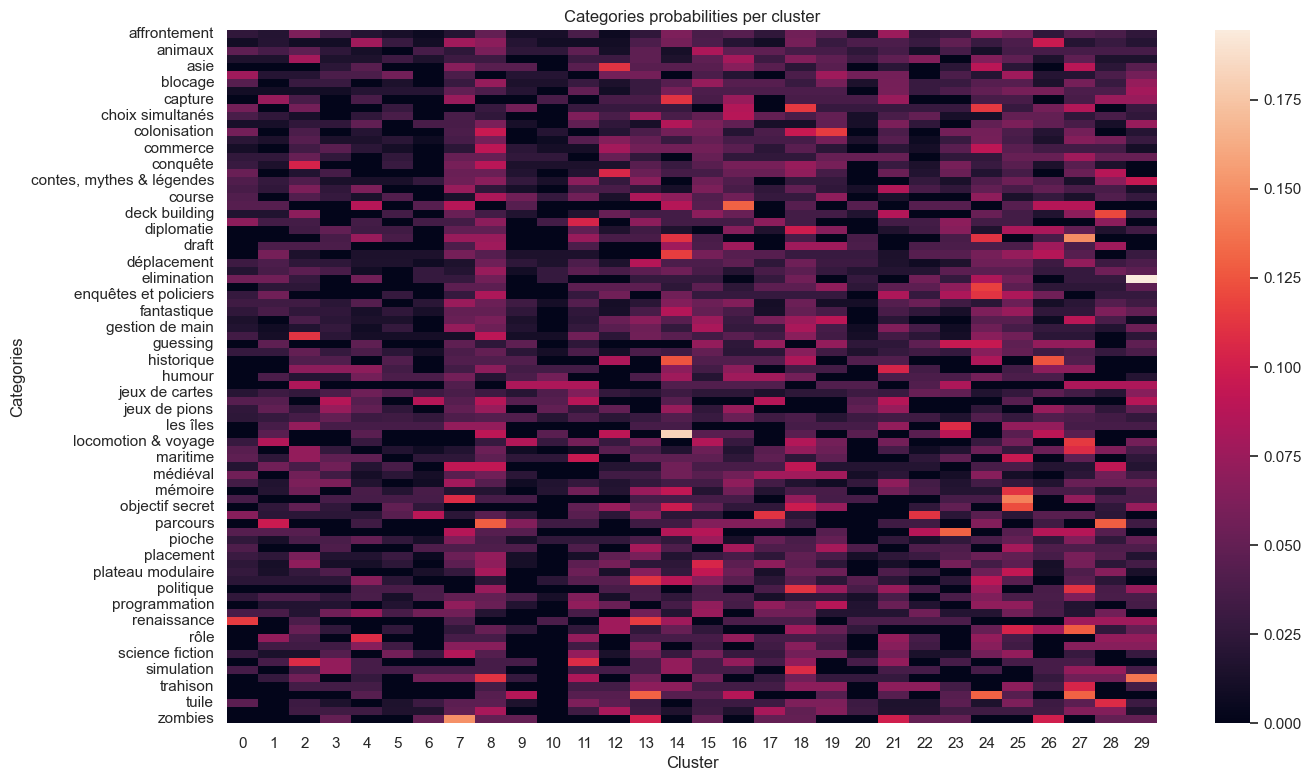

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
sns.heatmap(probas_cluster, ax=ax)
ax.set_title("Categories probabilities per cluster")
ax.set_ylabel("Categories")
#fig.savefig("../images/clusters_categories.png", format="png", bbox_inches="tight", dpi=150)

In [17]:
clusters_tags_freq = clusters_tags_normal.stack().to_frame().reset_index()
clusters_tags_freq.columns = ["Cluster", "Type", "Frequency"]
sorted = clusters_tags_freq.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_861/2047669260.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_freq.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Frequency', ascending=False).head(10))


In [18]:
COLUMN = "Frequency"
tag_per_clusters = clusters_tags_freq.groupby('Cluster').apply(lambda x: x.loc[x[COLUMN].nlargest(1).index, ["Cluster", "Type"]]).reset_index(drop=True)
games_clusters = pd.DataFrame(data={"Game id" : games_tags.index, "Cluster" : kmeans.labels_}).merge(tag_per_clusters, on="Cluster")

games_clusters["Type_cluster"] = games_clusters["Cluster"].astype(str) + " " + games_clusters["Type"]
tag_per_clusters

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_861/877406608.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  tag_per_clusters = clusters_tags_freq.groupby('Cluster').apply(lambda x: x.loc[x[COLUMN].nlargest(1).index, ["Cluster", "Type"]]).reset_index(drop=True)


,Cluster,Type
0,0,renaissance
1,1,parcours
2,2,guerre
3,3,jeux de dés
4,4,rôle
5,5,autres
6,6,observation
7,7,zombies
8,8,parcours
9,9,transport de marchandise


### Most common categories in each cluster

Text(0.5, 0.98, 'Games clusters')

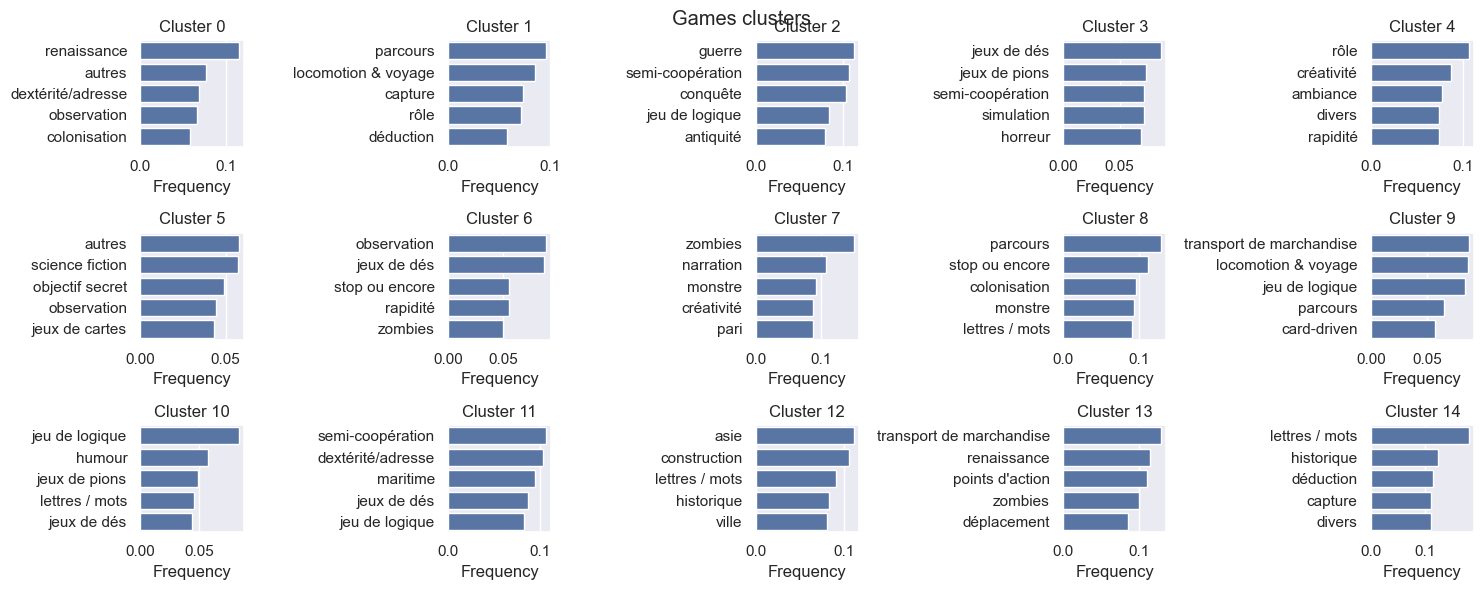

In [20]:
from itertools import product

NROWS, NCOLS = 3, 5
fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 6))
for i, j in product(range(NROWS), range(NCOLS)):
    cluster = i * NCOLS + j
    #if cluster > 6:
        #break
    data = sorted[sorted["Cluster"] == cluster].head(5)
    bars = sns.barplot(data, y="Type", x="Frequency", ax=axes[i, j])
    bars.set_ylabel("")
    bars.set_yticks(range(5))

    mean_rating = means[means["Cluster"] == cluster][("Rating", "mean")].item()
    #bars.set_title(f"Cluster {cluster}, mean rating : {mean_rating:.4f}")
    bars.set_title(f"Cluster {cluster}")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle("Games clusters")

###  Categories in each cluster ponderated by a distance to centroid. Closer to centroid -> more weight

In [21]:
CD = games_clusters_dist.pivot_table(index="Game id", columns="Cluster", values="Distance_centroid", fill_value=0).T
CS = games_clusters_dist.pivot_table(index="Game id", columns="Cluster", aggfunc='size', fill_value=0).T
CS = CS / CS.sum(axis=0)
clusters_distances = (1 / (CD @ games_tags / CS.sum(axis=1).values[:, None] )).replace(np.inf, 0)
clusters_tags_dist = clusters_distances * clusters_tags / clusters_distances.sum(axis=1).values[:, None]

clusters_tags_df = clusters_tags_dist.stack().to_frame().reset_index()
clusters_tags_df.columns = ["Cluster", "Type", "Weight"]
#clusters_tags_df.sort_values()
sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(5))

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_861/974731271.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sorted = clusters_tags_df.groupby(by='Cluster', group_keys=False).apply(lambda x: x.sort_values('Weight', ascending=False).head(5))


Text(0.5, 0.98, 'Games clusters (1 / distance from centroid)')

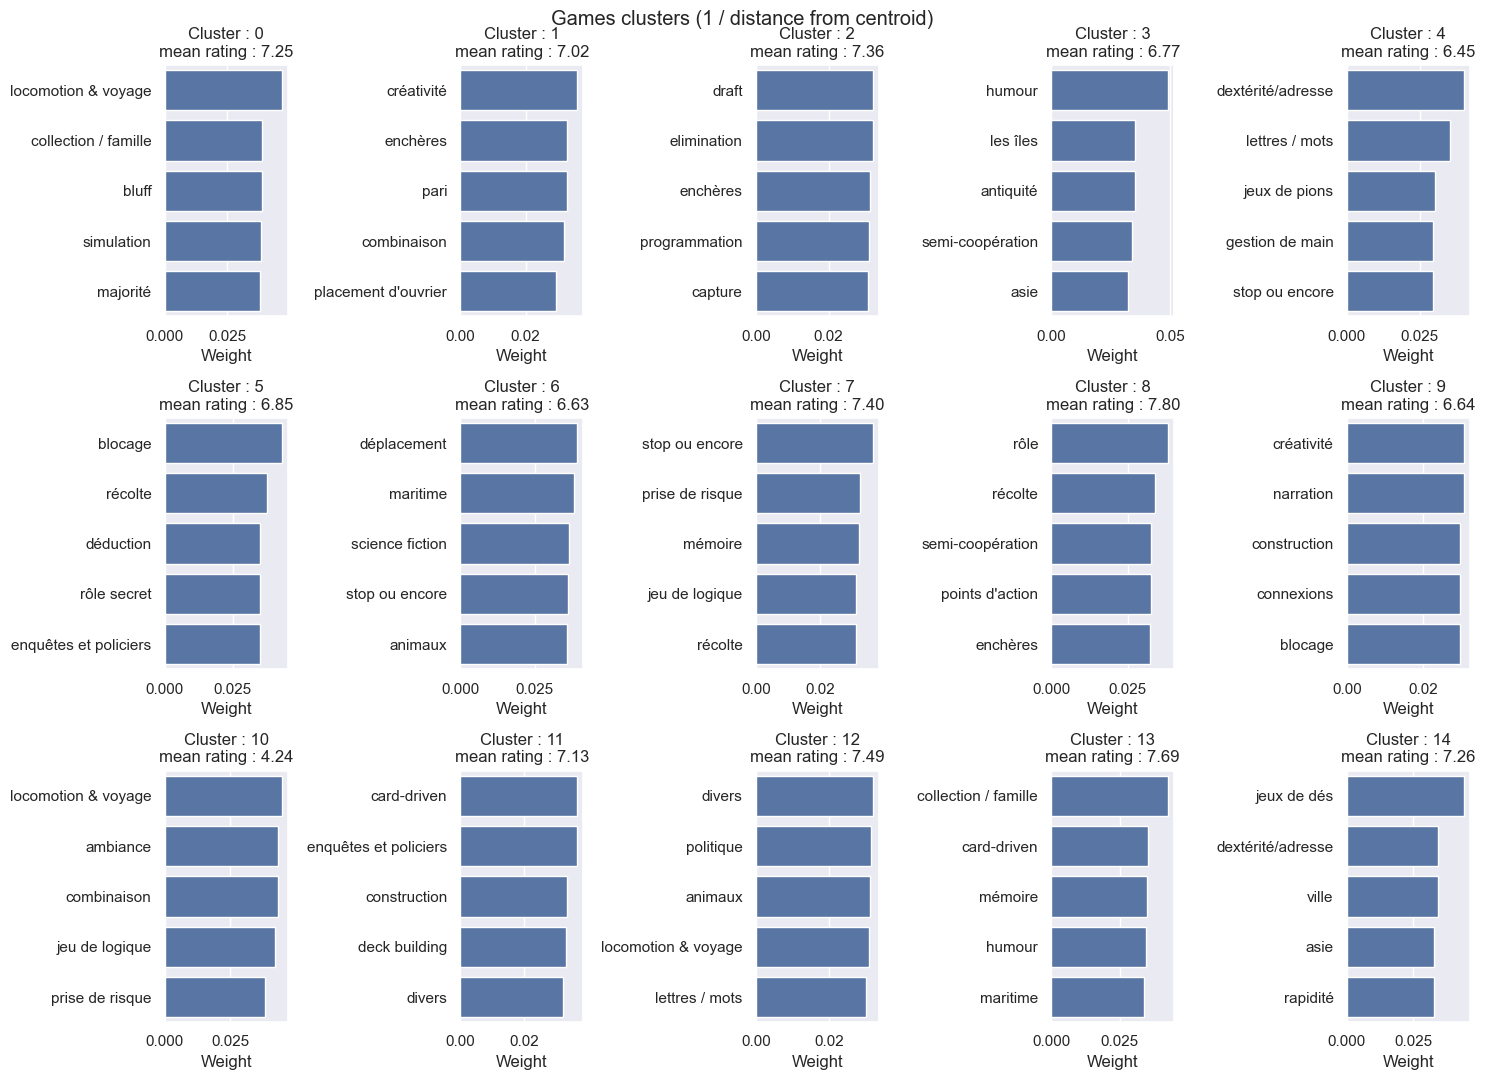

In [22]:
fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 11))
for i, j in product(range(NROWS), range(NCOLS)):
    cluster = i * NCOLS + j
    
    data = sorted[sorted["Cluster"] == cluster]
    bars = sns.barplot(data, y="Type", x="Weight", ax=axes[i, j])
    bars.set_ylabel("")
    bars.set_yticks(range(5))

    mean_rating = means[means["Cluster"] == cluster][("Rating", "mean")].item()
    bars.set_title(f"Cluster : {cluster}\nmean rating : {mean_rating:.2f}")

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.suptitle("Games clusters (1 / distance from centroid)")

In [23]:
G_embedded = TSNE(n_components=2, perplexity=50, max_iter=2000, random_state=1).fit_transform(G)

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_861/1540922848.py:13: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.scatterplot(data=data, x="x", y="y", hue="type", palette=palette, ax = axes[*axes_ind[ax]])
/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_861/1540922848.py:13: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.scatterplot(data=data, x="x", y="y", hue="type", palette=palette, ax = axes[*axes_ind[ax]])
/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_861/1540922848.py:13: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  ax = sns.scatterplot(data=data, x="x", y="y", hue="type", palette=palette, ax = axes[*axes_ind[ax]])
/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_861/1540922848.py:13: UserWarning: The palette list has more values (10) than needed (5), which may not 

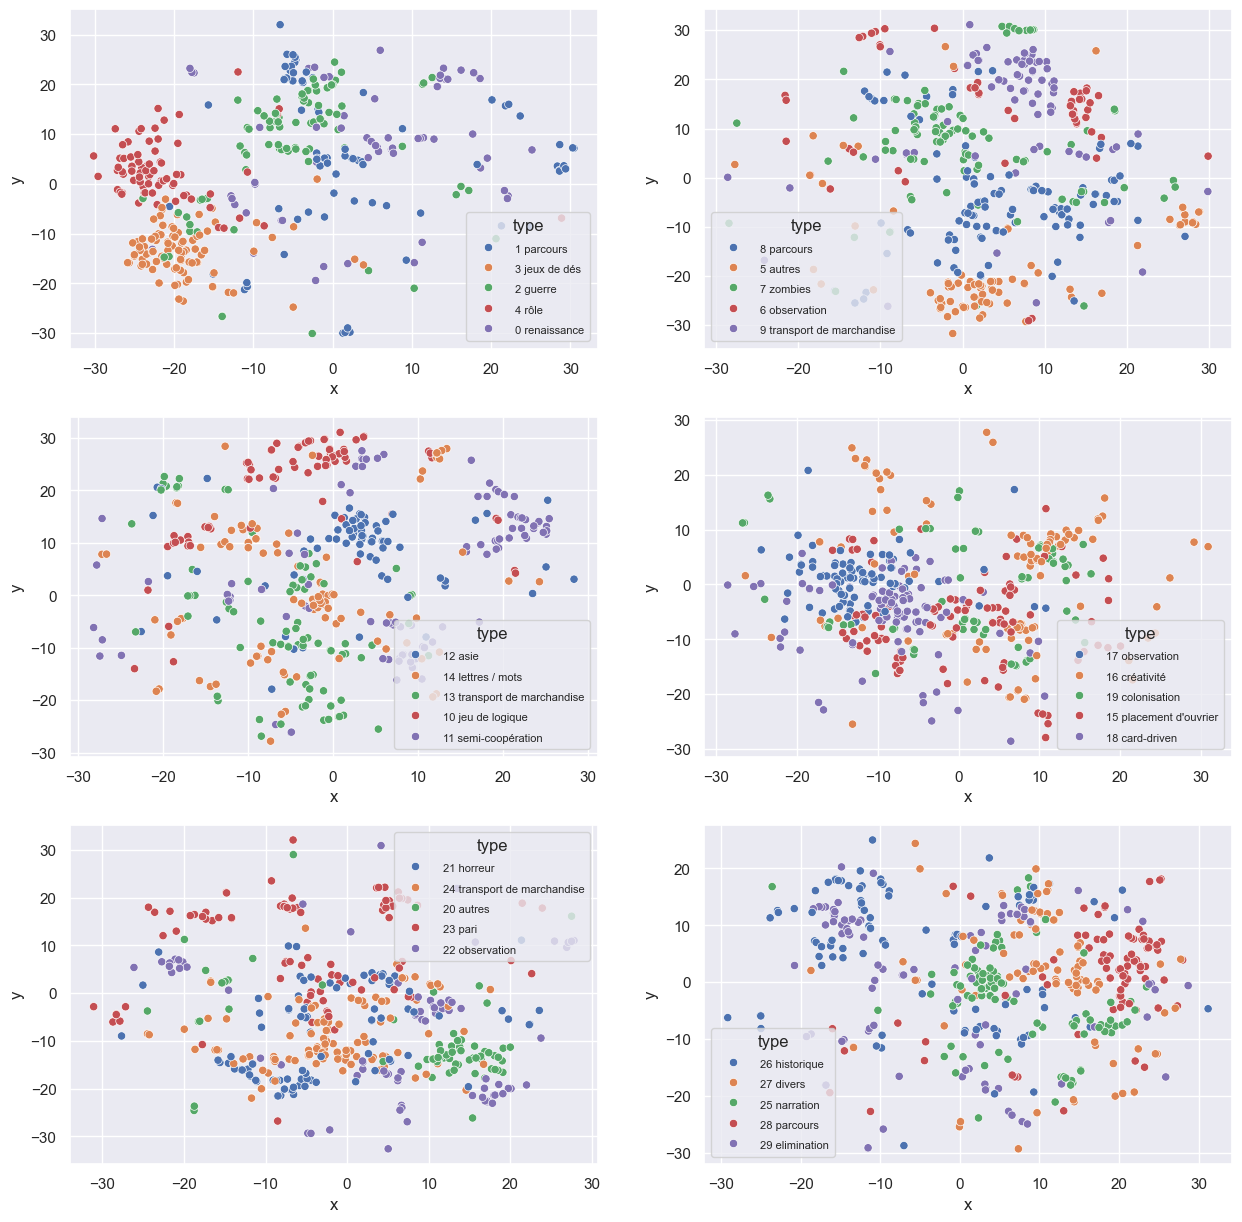

In [24]:
palette = sns.color_palette("deep")

NROWS, NCOLS = 3, 2
fig, axes = plt.subplots(NROWS, NCOLS, figsize=(15, 15))

indices = [np.arange(fst, fst + 5) for fst in range(0, NB_CLUSTERS, 5)]
#indices = [[3, 4, 2, 20], [24, 17, 5, 9], [12, 11, 10, 15], [8, 18, 22]]
axes_ind = list(product(range(NROWS), range(NCOLS)))

for ax, ind_to_plot in enumerate(indices):
    indices = games_clusters[games_clusters["Cluster"].isin(ind_to_plot)].index
    data = pd.DataFrame(data={"x":G_embedded[indices, 0], "y":G_embedded[indices, 1],"type":games_clusters.loc[indices, "Type_cluster"]})
    ax = sns.scatterplot(data=data, x="x", y="y", hue="type", palette=palette, ax = axes[*axes_ind[ax]])

    plt.setp(ax.get_legend().get_texts(), fontsize='8') # for legend text

## Co-occurence matrix

Text(0.5, 1.0, 'Cooc matrix (jaccard index)')

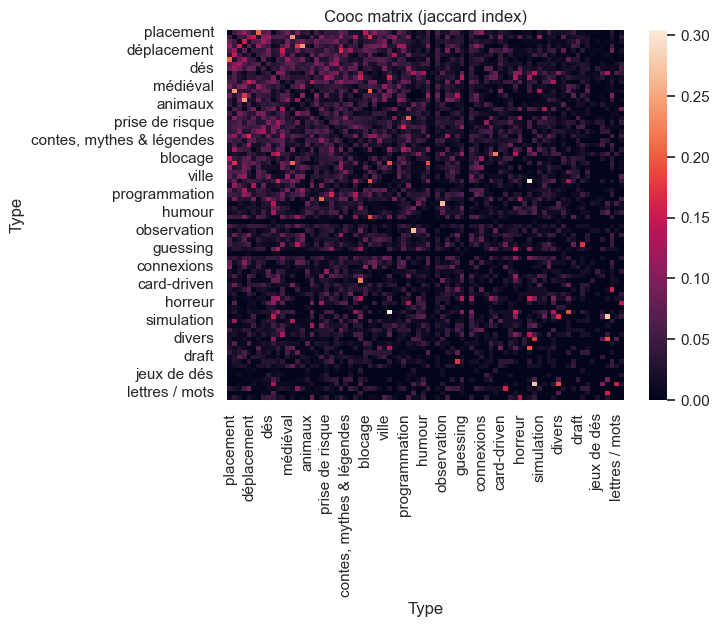

In [25]:
# !!! Important to reorder BEFORE projection
#games_tags = games_tags.loc[games_ids]

tags_select = tags_filter.tail(tags_filter.shape[0] - 3)["Type"].values
#tags_select = tags_filter["Type"].values
games_tags_select = games_tags.loc[:, tags_select]
games_to_delete = games_tags_select.sum(axis=1) != 0
games_tags_select = games_tags_select[games_to_delete]

cooc_matrix = games_tags_select.T @ games_tags_select
np.fill_diagonal(cooc_matrix.values, val=0)
cooc_freq = cooc_matrix.apply(sum, axis=1)
cooc_matrix = cooc_matrix.sort_values(by=cooc_matrix.columns.tolist(), ascending=False)
games_tags_select.shape
cooc_matrix = cooc_matrix.loc[cooc_matrix.columns, :] # reordering for jaccard index normalization

total_occ = np.tile(games_tags_select.sum(axis=0).values, (games_tags_select.shape[1], 1))
cooc_matrix = cooc_matrix / (total_occ + total_occ.T - cooc_matrix)
ax = sns.heatmap(cooc_matrix)
ax.set_title("Cooc matrix (jaccard index)")

/Users/bsh2022/Study/venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
/Users/bsh2022/Study/venv/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


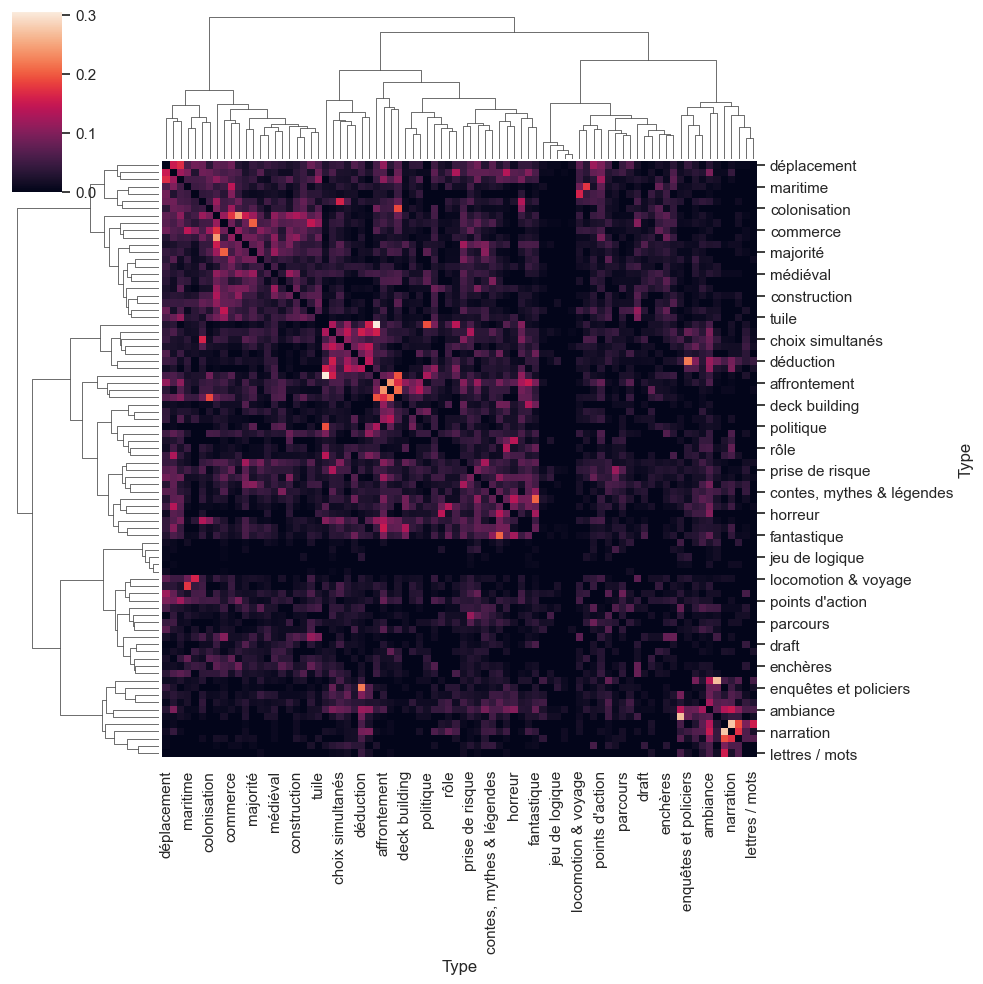

In [26]:
sns.set_theme(rc={"figure.figsize" : (15,9)})
ax = sns.clustermap(cooc_matrix, method="ward")

In [27]:
link_matrix_cooc = linkage(cooc_matrix, method="ward", metric="euclidean")
tags_cluster_labels = fcluster(link_matrix_cooc, 2, criterion="maxclust")
tags_cluster_labels

/var/folders/dp/qpw35dg90hv8n0247r1klh4c0000gn/T/ipykernel_861/58319813.py:1: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  link_matrix_cooc = linkage(cooc_matrix, method="ward", metric="euclidean")


array([1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2], dtype=int32)

<Axes: xlabel='Type', ylabel='Type'>

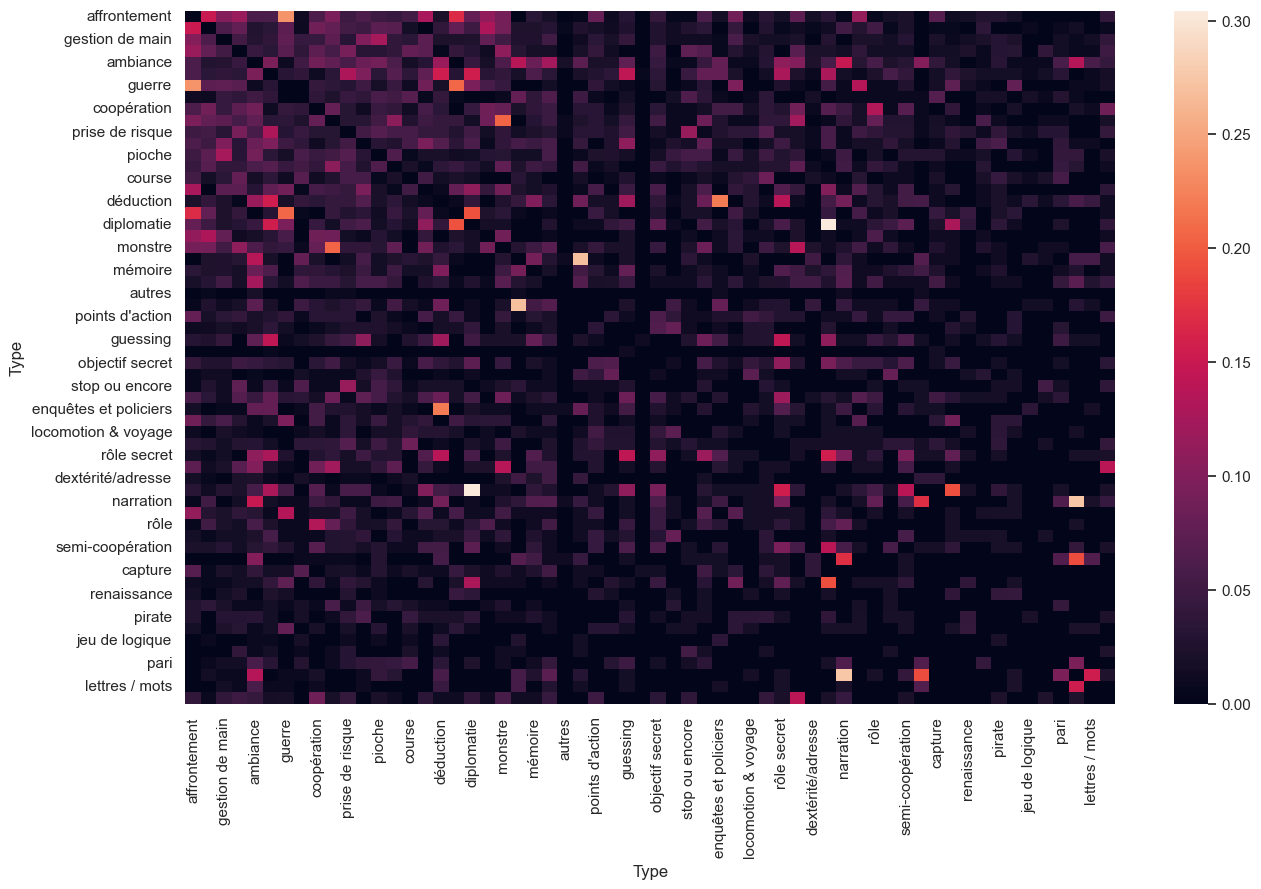

In [28]:
labels = cooc_matrix.index[tags_cluster_labels == 2]
reduced = cooc_matrix.loc[labels, labels]
sns.heatmap(reduced)

<Axes: xlabel='Type', ylabel='Type'>

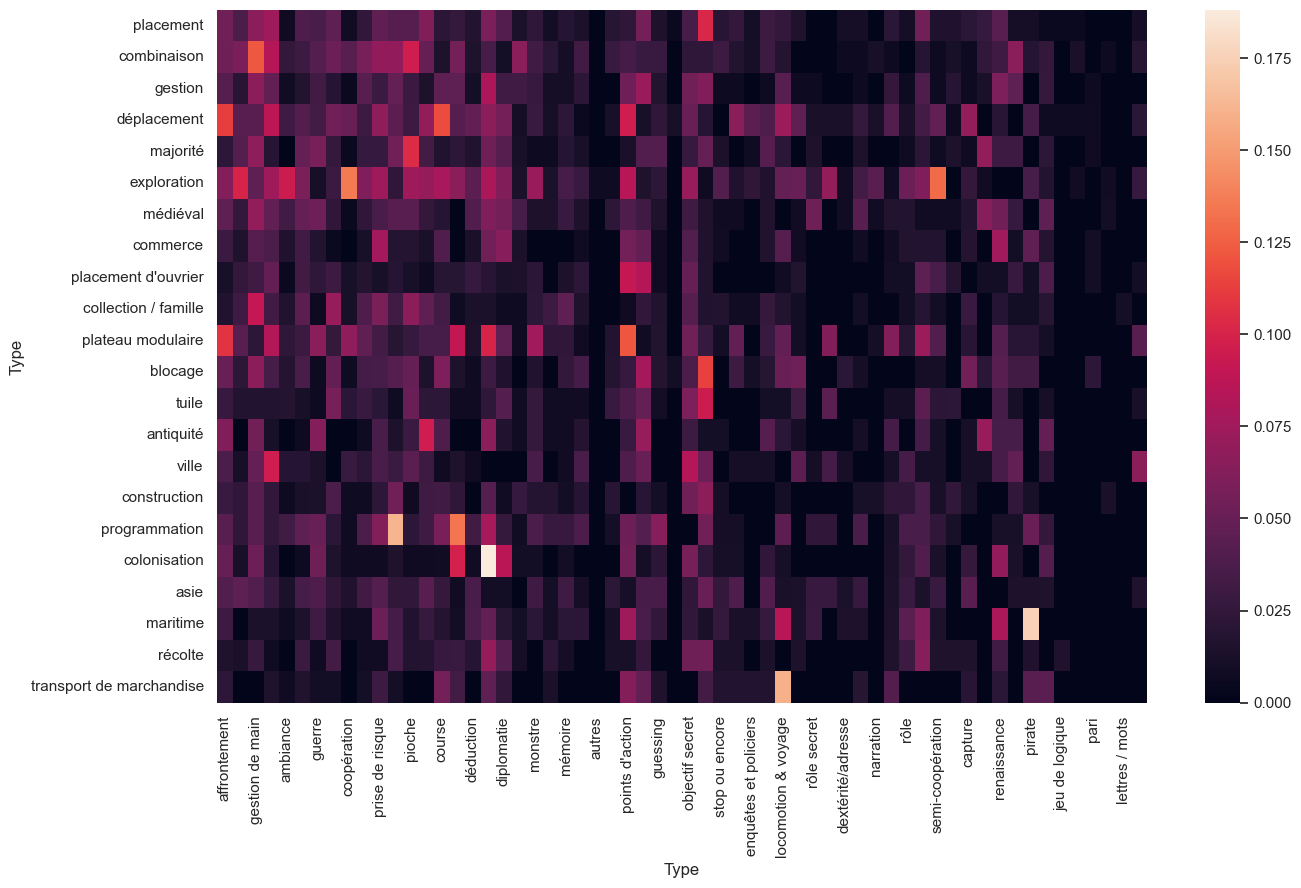

In [29]:
reduced = cooc_matrix.loc[cooc_matrix.index[tags_cluster_labels == 1], cooc_matrix.index[tags_cluster_labels == 2]]
sns.heatmap(reduced, annot=False)